In [2]:
%load_ext autoreload

import glob
import os

base_path = os.path.join(os.getcwd(), '..')
os.sys.path.append(base_path)

In [3]:
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple

from trainer.preprocess import PreprocessBatch
from trainer.preprocess import get_train_val_test_paths

In [4]:
names_train, names_test, paths_mesh, paths_vtu = get_train_val_test_paths('../data/raw/ex2')

In [5]:
pp = PreprocessBatch(is_train=False, path_output='', feature_name='')

pp.populate(names_test, paths_mesh, paths_vtu)

reading file: (9) Rc_1.0_h_30.5_tac_10.0_tel_16.6


In [7]:
case_name = 'Rc_1.0_h_20.2_tac_10.0_tel_6.0'

mesh1 = pp.mesh_data[case_name]
vtu1 = pp.vtu_data[case_name]

vtu1.keys(), mesh1.keys(), vtu1['connect'].dtype

(dict_keys(['coord', 'connect', 'solutions']),
 dict_keys(['coord', 'connect', 'groups_nodes', 'groups_element_nodes']),
 dtype('int32'))

In [8]:
def make_mesh(mesh_data):
    mesh = Delaunay(mesh_data['coord'])
    mesh.simplices = np.array(mesh_data['connect'])

    return mesh

make_mesh(mesh1).simplices.shape

(10528, 3)

In [9]:
mesh = make_mesh(mesh1)

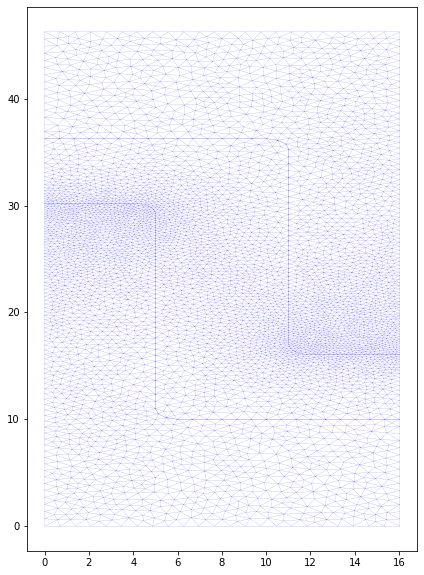

In [10]:
plt.figure(figsize=(7, 10))
triangulation = matplotlib.tri.Triangulation(mesh.points[:, 0], mesh.points[:, 1], mesh.simplices)
plt.triplot(triangulation, color='b', linewidth=.1, alpha=1.0);

In [11]:
df_encoded_geom = pd.DataFrame()

def dist_radial(x):
    return np.exp(-10 * x/(x.max()+1e-8))

for group, some_nodes in mesh1['groups_nodes'].items():
    some_coord = mesh1['coord'][some_nodes]
    dist_node_to_boundary = cdist(mesh1['coord'], some_coord)
    
    dist_node_to_boundary = np.min(dist_node_to_boundary, axis=1)
    dist_node_to_boundary = dist_radial(dist_node_to_boundary)
    
    df_encoded_geom[group] = dist_node_to_boundary

In [12]:
 df_encoded_geom.head()

,leftEdgeSPE,leftEdgeCathode,leftEdgeAnode,yZero,rightEdgeAnode,rightEdgeSPE,rightEdgeCathode,yTop,intCatElCathode,intCatElSPE,intAnElSPE,intAnElAnode
0,0.000146,0.000107,1.000000,0.860164,0.017480,0.004000,0.000045,0.000045,0.000045,0.000045,0.002999,0.002999
1,0.000045,0.000045,0.000849,1.000000,0.845203,0.053786,0.000849,0.000045,0.000311,0.000311,0.006411,0.006411
2,0.004000,0.017541,0.000045,0.000045,0.000107,0.000146,1.000000,0.860163,0.002999,0.002999,0.000045,0.000045
3,0.053786,1.000000,0.000849,0.000045,0.000045,0.000045,0.000849,0.860164,0.006411,0.006411,0.000311,0.000311
4,1.000000,0.218600,1.000000,0.001450,0.001488,0.001914,0.000849,0.031185,0.047098,0.047098,0.904141,0.904141


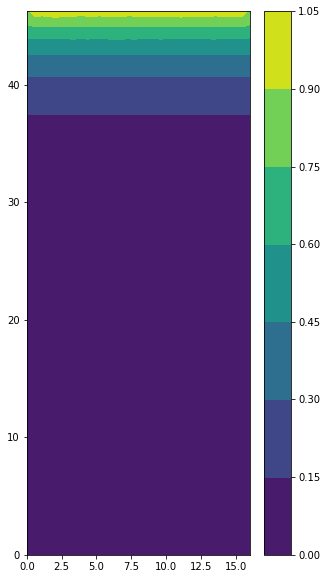

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))

triangulation = matplotlib.tri.Triangulation(mesh.points[:, 0], mesh.points[:, 1], mesh.simplices)
ax_cont = ax.tricontourf(triangulation, df_encoded_geom['yTop']);
fig.colorbar(ax_cont, ax=ax)